# Import Package

In [7]:
!pip install --upgrade imgaug

Requirement already up-to-date: imgaug in /anaconda/envs/azureml_py36/lib/python3.6/site-packages (0.4.0)


In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace, Dataset

from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
import random
import imgaug.augmenters as iaa
from tensorflow.keras.utils import Sequence
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import CategoricalCrossentropy
from tensorflow import keras
import time
from datetime import datetime

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.31.0


# Connect to a Workspace

In [5]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, sep='\t')

oc-p8	westeurope	oc-p8-ressource-group


# Get registered dataset

Datasets have been manually registerd via the GUI of the Azure machine learning studio

In [6]:
img_train = Dataset.get_by_name(ws, 'images_train_ds')
mask_train = Dataset.get_by_name(ws, 'mask_train')
img_val = Dataset.get_by_name(ws, 'images_val')
mask_val = Dataset.get_by_name(ws, 'mask_val')

# Utilities

In [6]:
def create_mask(img,cats):
    '''creates an mask from image and segmentation categories
    
    Args:
      img - PIL image
      cats - dict {'cat1':[value1,value2,value3,etc...],'cat2':[value1,value2,value3,etc...]}
    
    Returns:
      A mask of type np.array of dimension (shape(img),len(cats)) '''
    
    
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32) # convert img to np.array
    img=np.squeeze(img) #remove 1 dimension
    mask = np.zeros((img.shape[0], img.shape[1], len(cats)),dtype=int) # create a mask with zeros
    flat_cat = [val for cat in list(cats.values()) for val in cat] # create a list of all values associated with categories
    ca_min=min(flat_cat)
    ca_max=max(flat_cat)
    cats_names=list(cats.keys())
    
    #for each values associated with a category, fill in the mask with the corresponding category number
    for i in range(ca_min,ca_max):
            for idx,name in enumerate(cats_names):
                if i in cats[name]:
                    mask[:,:,idx] = np.logical_or(mask[:,:,idx],(img==i))
    return mask


def generate_img_from_mask(mask,cats,colors_palette=['b','g','r','c','m','y','k','w']):
    
    '''Generate a PIL image from a segmented mask and categorie cats with specified color palette for each cateorie
    
    Args:
      mask - numpy array of dimension (shape(img),len(cats))
      cats - dict {'cat1':[value1,value2,value3],'cat2':[value1,value2,value3]}
    
    Returns
      PIL image'''
    img_seg = np.zeros((mask.shape[0],mask.shape[1],3),dtype='float')
    for cat in range(len(cats)):
        img_seg[:,:,0] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[0]
        img_seg[:,:,1] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[1]
        img_seg[:,:,2] += mask[:,:,cat]*colors.to_rgb(colors_palette[cat])[2]
        
    return tf.keras.preprocessing.image.array_to_img(img_seg)  

def normalize_input_img(img):
    '''Normalize PIL image to fall in [-1,1] range, returns 3D numpy array'''
    img =tf.keras.preprocessing.image.img_to_array(img,dtype=np.int32)
    img = img/127.5
    img -= 1
    return img

def get_concat_h(im1, im2):
    
    '''concatenate two PIL images horizontaly'''
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def show_results(img,mask,model):
    
    '''concatenates the img, the reference mask and the predicted mask'''

    img_norm = np.array(normalize_input_img(img))
    
    img_pred = model.predict(img_norm.reshape(1,128,256,3))[0]
    
    res = get_concat_h(get_concat_h(img,generate_img_from_mask(create_mask(mask,cats),cats)),generate_img_from_mask(img_pred,cats))
    
    return res

# Creating the model

In [25]:
#https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
# assign to a variable
vgg_weights_path = "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [26]:
def block(x, n_convs, filters, kernel_size, activation, pool_size, pool_stride, block_name):
  '''
  Defines a block in the VGG network.

  Args:
    x (tensor) -- input image
    n_convs (int) -- number of convolution layers to append
    filters (int) -- number of filters for the convolution layers
    activation (string or object) -- activation to use in the convolution
    pool_size (int) -- size of the pooling layer
    pool_stried (int) -- stride of the pooling layer
    block_name (string) -- name of the block

  Returns:
    tensor containing the max-pooled output of the convolutions
  '''

  for i in range(n_convs):
      x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size,
                                 activation=activation, padding='same', name="{}_conv{}".format(block_name, i + 1))(x)
    
  x = tf.keras.layers.MaxPooling2D(pool_size=pool_size, 
                                   strides=pool_stride, name="{}_pool{}".format(block_name, i+1 ))(x)

  return x

In [27]:
def VGG_16(image_input):
  '''
  This function defines the VGG encoder.

  Args:
    image_input (tensor) - batch of images

  Returns:
    tuple of tensors - output of all encoder blocks plus the final convolution layer
  '''

  # create 5 blocks with increasing filters at each stage. 
  # you will save the output of each block (i.e. p1, p2, p3, p4, p5). "p" stands for the pooling layer.
  x = block(image_input,n_convs=2, filters=64, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block1')
  p1= x

  x = block(x,n_convs=2, filters=128, kernel_size=(3,3),
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block2')
  p2 = x

  x = block(x,n_convs=3, filters=256, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block3')
  p3 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block4')
  p4 = x

  x = block(x,n_convs=3, filters=512, kernel_size=(3,3), 
            activation='relu',pool_size=(2,2), pool_stride=(2,2), block_name='block5')
  p5 = x

  # create the vgg model
  vgg  = tf.keras.Model(image_input , p5)

  # load the pretrained weights you downloaded earlier
  vgg.load_weights(vgg_weights_path) 

  # number of filters for the output convolutional layers
  n = 4096

  # our input images are 224x224 pixels so they will be downsampled to 7x7 after the pooling layers above.
  # we can extract more features by chaining two more convolution layers.
  c6 = tf.keras.layers.Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6")(p5)
  c7 = tf.keras.layers.Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7")(c6)

  # return the outputs at each stage. you will only need two of these in this particular exercise 
  # but we included it all in case you want to experiment with other types of decoders.
  return (p1, p2, p3, p4, c7)

In [28]:
def fcn8_decoder(convs, n_classes):
  '''
  Defines the FCN 8 decoder.

  Args:
    convs (tuple of tensors) - output of the encoder network
    n_classes (int) - number of classes

  Returns:
    tensor with shape (height, width, n_classes) containing class probabilities
  '''

  # unpack the output of the encoder
  f1, f2, f3, f4, f5 = convs
  
  # upsample the output of the encoder then crop extra pixels that were introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])
  
  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)

  # append a softmax to get the class probabilities
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [29]:
def segmentation_model():
  '''
  Defines the final segmentation model by chaining together the encoder and decoder.

  Returns:
    keras Model that connects the encoder and decoder networks of the segmentation model
  '''
  
  inputs = tf.keras.layers.Input(shape=(128,256,3))
  convs = VGG_16(image_input=inputs)
  outputs = fcn8_decoder(convs, 8)
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  
  return model

In [30]:
# instantiate the model and see how it looks
model_fcn8 = segmentation_model()
model_fcn8.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool2 (MaxPooling2D)     (None, 64, 128, 64)  0           block1_conv2[0][0]               
____________________________________________________________________________________________

# Metrics

In [63]:
def class_wise_IoU(y_true,y_pred):
    
    nb_class = y_true.shape[3]
    
    # for each pixel, get the slice number which has the highest probability
    y_true = K.argmax(y_true, axis=3)
    y_pred = K.argmax(y_pred,axis=3)
    
    class_wise_iou = []
  
    smoothening_factor = 0.00001 # to avoid eventual division by 0
    
    for i in range(nb_class):
        pred = tf.cast((y_pred == i),tf.float32)
        truth = tf.cast((y_true == i),tf.float32)
        intersection = K.sum(pred * truth)
        y_true_area = K.sum(truth)
        y_pred_area = K.sum(pred)
        combined_area = y_true_area + y_pred_area
    
        iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
        class_wise_iou.append(iou)  
    
    return tf.convert_to_tensor(class_wise_iou)

In [16]:
def mean_IoU(y_true,y_pred):   
    y_true = tf.cast(y_true, tf.float32)   
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)
    return score

# Datagenerators and augmentation

In [10]:
def blur_img(img):
    '''Add random blur to image, returns PIL image'''
    n = random.uniform(0,2.0) # Generating random value for sigma
    blur_transform = iaa.Sequential([iaa.GaussianBlur(sigma=n)])
    img_blur = blur_transform(image=tf.keras.preprocessing.image.img_to_array(img))

    return tf.keras.preprocessing.image.array_to_img(img_blur)

def zoom_img(img,mask):
    '''Add random zoom to image and mask, returns transformed PIL image and corresponding mask'''
    n = random.uniform(1,5) # Generating random value for sigma
    zoom_transform = iaa.Sequential([iaa.Affine(scale=n,order=0)]) # uses order=0 to avoid artifacts in mask
    img_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_zoom = zoom_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_zoom), tf.keras.preprocessing.image.array_to_img(mask_zoom,scale=False)

def brightness_img(img):
    '''Add random brightness to image, returns PIL image'''
    br_transform = iaa.Sequential([iaa.MultiplyBrightness((0.1,2))])
    img_br = br_transform(image=tf.keras.preprocessing.image.img_to_array(img).astype(np.uint8))
    
    return tf.keras.preprocessing.image.array_to_img(img_br,scale=False)

def flip_img(img,mask):
    '''Flips verticaly image, returns transformed PIL image and corresponding mask'''
    flip_transform = iaa.Sequential([iaa.Fliplr()])
    img_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(img))
    mask_flip = flip_transform(image=tf.keras.preprocessing.image.img_to_array(mask))

    return tf.keras.preprocessing.image.array_to_img(img_flip), tf.keras.preprocessing.image.array_to_img(mask_flip,scale=False)

In [11]:
class seg_gen(Sequence):
    
    def __init__(self, image_filename,
                 mask_filename,
                 batch_size,
                 img_height,
                 img_width,
                 cats,
                 sample_perc=100,
                 aug_blur=False,
                 aug_zoom=False,
                 aug_brightness=False,
                 aug_flip=False):
        
        #self.image_dir = image_dir
        #self.mask_dir =  mask_dir
        #self.image_filename =  os.listdir(image_dir)
        self.image_filename = image_filename
        self.image_filename.sort()
        #self.mask_filename =  os.listdir(mask_dir)
        self.mask_filename = mask_filename
        self.mask_filename.sort()
        self.sample_perc = sample_perc
        # Generate a sample
        rdm_index = random.sample(range(0,len(self.image_filename)),int(len(self.image_filename)*self.sample_perc/100))
        image_filename_sample = []
        for i in rdm_index:
            image_filename_sample.append(self.image_filename[i])
            
        mask_filename_sample = [] 
        for i in rdm_index:
            mask_filename_sample.append(self.mask_filename[i])
                
        self.image_filename = image_filename_sample
        self.mask_filename = mask_filename_sample
        
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.cats = cats
        self.sample_perc = sample_perc
        self.aug_blur = aug_blur
        self.aug_zoom = aug_zoom
        self.aug_brightness = aug_brightness
        self.aug_flip = aug_flip

    def __len__(self):
        return int(np.ceil(len(self.image_filename) / float(self.batch_size)))

    def __getitem__(self, idx):
        'generate one batch with random index'
        
        idx = np.random.randint(0,len(self.image_filename)-1, self.batch_size) #generate random index for the batch
        batch_img, batch_mask = [], []
        
        for i in idx:
            
            #filename
            #img_file = self.image_dir+'/'+self.image_filename[i] 
            #mask_file = self.mask_dir+'/'+self.mask_filename[i]
            img_file = self.image_filename[i] 
            mask_file = self.mask_filename[i]
            
            #Load as PIL image and resize
            img = tf.keras.preprocessing.image.load_img(img_file,target_size=(self.img_height,self.img_width))
            mask = tf.keras.preprocessing.image.load_img(mask_file,target_size=(128,256),color_mode="grayscale")
                        
            #Normalize image and create mask from greyscale image
            img_norm = normalize_input_img(img)
            mask_tensor = create_mask(mask,self.cats)            
          
            #Add to the batch
            batch_img.append(img_norm)
            batch_mask.append(mask_tensor)
            
            #Image augmentation
            if self.aug_blur:
                batch_img.append(normalize_input_img(blur_img(img)))
                batch_mask.append(mask_tensor) # When using blur augmentation,the mask is not changed
            
            if self.aug_zoom:
                zooms = zoom_img(img,mask)
                batch_img.append(normalize_input_img(zooms[0]))
                batch_mask.append(create_mask(zooms[1],self.cats))
             
            if self.aug_brightness:
                batch_img.append(normalize_input_img(brightness_img(img)))
                batch_mask.append(mask_tensor) # When using brightness augmentation,the mask is not changed
            
            if self.aug_flip:
                flips = flip_img(img,mask)
                batch_img.append(normalize_input_img(flips[0]))
                batch_mask.append(create_mask(flips[1],self.cats))            
              
            
        return np.array(batch_img), np.array(batch_mask)

In [12]:
cats = {'void': [0, 1, 2, 3, 4, 5, 6],
 'flat': [7, 8, 9, 10],
 'construction': [11, 12, 13, 14, 15, 16],
 'object': [17, 18, 19, 20],
 'nature': [21, 22],
 'sky': [23],
 'human': [24, 25],
 'vehicle': [26, 27, 28, 29, 30, 31, 32, 33, -1]}

In [17]:
train_gen = seg_gen(img_train.download(),mask_train.download(),10,128,256,cats,sample_perc=100,aug_blur=False,aug_zoom=True,aug_brightness=False,aug_flip=True)

In [18]:
val_gen = seg_gen(img_val.download(),mask_val.download(),10,128,256,cats,sample_perc=100,aug_blur=False,aug_zoom=False,aug_brightness=False,aug_flip=False)

# Callbacks

Early Stopping

In [23]:
es = tf.keras.callbacks.EarlyStopping(mode='max', monitor='val_mean_IoU', patience=6, verbose=1)

Model check point

In [24]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='Users/yann.hereng.openclassrooms/Chekpoint',
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

To load model weights (that are considered the best) into the model:
model.load_weights(checkpoint_filepath)

# Train the model

In [25]:
sgd = tf.keras.optimizers.SGD(learning_rate =1E-2, momentum=0.9, nesterov=True)
model_fcn8.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[mean_IoU,'accuracy'],
              run_eagerly=True
              )

start = time.time()
hist = model_fcn8.fit(train_gen,validation_data = val_gen, epochs=200, callbacks=[es,model_checkpoint_callback])
stop = time.time()

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 298 steps, validate for 50 steps
Epoch 1/200
298/298 [==============================] - 498s 2s/step - loss: 0.5887 - mean_IoU: 0.5630 - accuracy: 0.8079 - val_loss: 0.5412 - val_mean_IoU: 0.5845 - val_accuracy: 0.8197
Epoch 2/200
298/298 [==============================] - 499s 2s/step - loss: 0.5274 - mean_IoU: 0.5981 - accuracy: 0.8265 - val_loss: 0.5011 - val_mean_IoU: 0.6079 - val_accuracy: 0.8324
Epoch 3/200
298/298 [==============================] - 499s 2s/step - loss: 0.5025 - mean_IoU: 0.6125 - accuracy: 0.8334 - val_loss: 0.5020 - val_mean_IoU: 0.6117 - val_accuracy: 0.8306
Epoch 4/200
298/298 [==============================] - 500s 2s/step - loss: 0.4852 - mean_IoU: 0.6217 - accuracy: 0.8382 - val_loss: 0.4928 - val_mean_IoU: 0.6360 - val_accuracy: 0.8316
Epoch 5

In [27]:
import os
model_fcn8.save('my_model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: my_model/assets


In [28]:
from azureml.core.model import Model
model = Model.register(ws, model_name='FCN8', model_path=os.getcwd()+'/my_model')

Registering model FCN8


In [88]:
hist.history

{'loss': [2.0770857334136963,
  2.0665009021759033,
  2.0692026615142822,
  2.068567156791687,
  2.0626550912857056],
 'mean_IoU': [0.066623956, 0.06644414, 0.06648617, 0.06648221, 0.0663876],
 'accuracy': [0.122241825, 0.122217104, 0.12203094, 0.12294281, 0.12310944],
 'val_loss': [2.0619208812713623,
  2.063771629333496,
  2.060463309288025,
  2.0603586196899415,
  2.0635818004608155],
 'val_mean_IoU': [0.06636281, 0.06639179, 0.066340044, 0.06634174, 0.06639844],
 'val_accuracy': [0.122600704, 0.12238312, 0.12260559, 0.12275208, 0.12303009]}

# Testing the model

In [68]:
model = keras.models.load_model('my_model', compile = False)

In [70]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True
              )

In [4]:
import tensorflow as tf
import numpy as np

In [5]:
test_img_file='aachen_000141_000019_leftImg8bit.png'
test_mask_file='aachen_000141_000019_gtFine_labelIds.png'
img = tf.keras.preprocessing.image.load_img(test_img_file,target_size=(128,256))
img_norm = np.array(normalize_input_img(img))
mask = tf.keras.preprocessing.image.load_img(test_mask_file,target_size=(128,256),color_mode="grayscale")

NameError: name 'normalize_input_img' is not defined

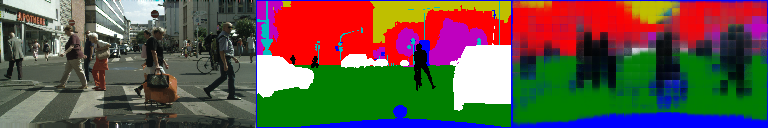

In [72]:
show_results(img,mask,model)

In [73]:
model_final= keras.models.load_model('final_model')

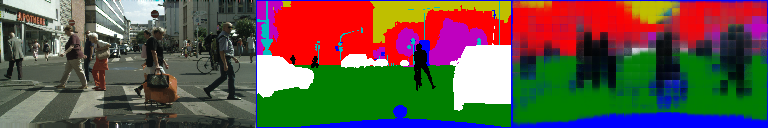

In [74]:
show_results(img,mask,model_final)

In [93]:
pred = model_final.predict(img_norm.reshape(1,128,256,3))
np.shape(pred)

(1, 128, 256, 8)

In [98]:
class_wise_IoU(model_final.predict(img_norm.reshape(1,128,256,3)),create_mask(mask,cats).reshape(1,128,256,8)).numpy()

array([4.5291480e-01, 5.0073111e-01, 5.1260877e-01, 1.5015015e-08,
       3.8759694e-02, 3.4127295e-01, 3.1882282e-02, 1.7914725e-09],
      dtype=float32)

In [47]:
img_train.as_mount()

In [14]:
T =img_train.as_mount()


In [46]:
len(img_train.to_path())

2975

# Create and experience

In [3]:
#Creating an experience

from azureml.core import Experiment
experiment_name = 'Segmentation-model-training'

exp = Experiment(workspace=ws, name=experiment_name)

In [4]:
#creating compute ressources

from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpu-cluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

creating a new compute target...
Creating........
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned
{'currentNodeCount': 0, 'targetNodeCount': 0, 'nodeStateCounts': {'preparingNodeCount': 0, 'runningNodeCount': 0, 'idleNodeCount': 0, 'unusableNodeCount': 0, 'leavingNodeCount': 0, 'preemptedNodeCount': 0}, 'allocationState': 'Steady', 'allocationStateTransitionTime': '2021-06-25T09:41:18.694000+00:00', 'errors': None, 'creationTime': '2021-06-25T09:40:46.147090+00:00', 'modifiedTime': '2021-06-25T09:41:26.741389+00:00', 'provisioningState': 'Succeeded', 'provisioningStateTransitionTime': None, 'scaleSettings': {'minNodeCount': 0, 'maxNodeCount': 4, 'nodeIdleTimeBeforeScaleDown': 'PT120S'}, 'vmPriority': 'Dedicated', 'vmSize': 'STANDARD_D2_V2'}
